In [1]:
import torch
import os
import json
import numpy as np
import pickle

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt 

In [2]:
parent_path = "../neurips/"
run = ''
approach = "abstractbeam"
os.getcwd()
os.listdir(parent_path + "abstractbeam/models")

['model-best-valid.ckpt', 'logs', 'model-latest.ckpt']

In [3]:
with open(parent_path + f"{approach}/models{run}/model-latest.ckpt", "rb") as f:
    ckpt = torch.load(f)  # , map_location=torch.device("mps"))

In [4]:
ckpt['domain'].operations

[Add,
 Subtract,
 Multiply,
 IntDivide,
 Square,
 Min,
 Max,
 Greater,
 Less,
 Equal,
 IsEven,
 IsOdd,
 If,
 Head,
 Last,
 Take,
 Drop,
 Access,
 Minimum,
 Maximum,
 Reverse,
 Sort,
 Sum,
 Map,
 Filter,
 Count,
 ZipWith,
 Scanl1,
 fn_0,
 fn_1,
 fn_3,
 fn_5,
 fn_6]

In [5]:
ckpt["higher_order_functions"]

{'Map': [1, 0],
 'Filter': [1, 0],
 'Count': [1, 0],
 'ZipWith': [2, 0, 0],
 'Scanl1': [2, 0],
 'fn_1': [1, 0],
 'fn_6': [1, 0]}

In [6]:
inventions = ckpt["inventions"]
for inv in inventions:
    print(inv.name, inv.program, inv.arity)

fn_0 Count((lambda v1: Less(v1, x1)), x2) 2
fn_1 x1(Min(Add(1, 1), x2)) 2
fn_3 Add(-1, x1) 1
fn_5 Count((lambda v1: Equal(v1, x1)), x2) 2
fn_6 x1(Min(fn_3(1), x2)) 2


In [7]:
constants = ckpt["domain"].constants
print(f"initial constants: {[-1, 1]}")
print(f"now: {constants}")

initial constants: [-1, 1]
now: [-1, 1, 0]


In [8]:
with open(parent_path + f"{approach}/results{run}/run_1.json", "rb") as json_file:
    results = json.load(json_file)
solutions = [ele for ele in results["results"] if ele["success"]]
len(solutions) / len(results["results"]) * 100

40.0

0.4000000059604645 0.3799999952316284


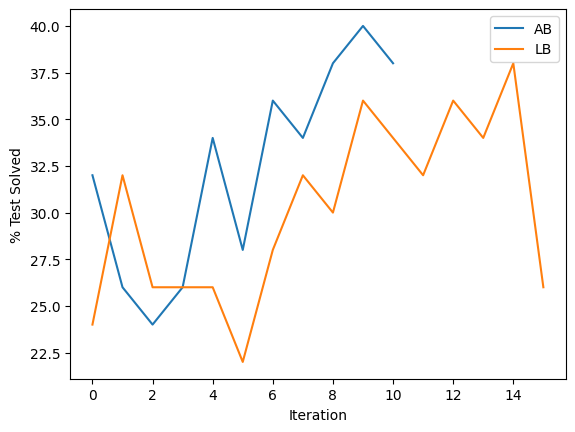

In [18]:
path_dict = {"dws-07": ["events.out.tfevents.1714053475.dws-07.3890530.0", "events.out.tfevents.1714032509.dws-07.3771435.0"],
             "dws-08": ["events.out.tfevents.1713809260.dws-08.1791531.0", "events.out.tfevents.1713809260.dws-08.1791531.0", "events.out.tfevents.1714053514.dws-08.29892.0"],
             "dws-16": ["events.out.tfevents.1714053338.dws-16.29135.0"],
             "dws-06": ["events.out.tfevents.1713428257.dws-06.1874500.0", "events.out.tfevents.1713532162.dws-06.528186.0"]}
# Path to your event file or directory
ab_file = f'../neurips/abstractbeam/models/logs/'
scalars_AB, times = [], []
for file in path_dict["dws-07"]: 
    # Initialize an event accumulator
    event_AB = EventAccumulator(ab_file + file)
    event_AB.Reload()
    scalars = event_AB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_AB += [ele.value for ele in scalars]

inds = np.argsort(times)
scalars_AB = np.array(scalars_AB)[inds] 

lb_file = parent_path + f'lambdabeam/models/logs/'
scalars_LB, times = [], []
for file in path_dict["dws-06"]: 
    # Initialize an event accumulator
    event_LB = EventAccumulator(lb_file + file)
    event_LB.Reload()
    scalars = event_LB.Scalars('eval/succ')
    times += [ele.wall_time for ele in scalars]
    scalars_LB += [ele.value for ele in scalars]

plt.plot(np.array(scalars_AB) * 100, label="AB")
plt.plot(np.array(scalars_LB) * 100, label="LB")
plt.ylabel("% Test Solved")
plt.xlabel("Iteration")
plt.legend()

print(max(scalars_AB), max(scalars_LB))

In [16]:
programs = [ele["solution"] for ele in solutions]
for op in ckpt['domain'].operations:
    found = False
    for p in programs:
        if str(op) in p:
            print(f"Found {op}: {p}")
            found = True
            break
    if not found:
        print(f"Not Found: {op}.")
            

Found Add: Multiply(k, Add(1, IntDivide(x, k)))
Found Subtract: Map((lambda u1: ((lambda v1: fn_3(((lambda v1: Square(((lambda v1: Subtract(v1, -1)))(v1))))(v1))))(u1)), x)
Found Multiply: Multiply(k, Add(1, IntDivide(x, k)))
Found IntDivide: Multiply(k, Add(1, IntDivide(x, k)))
Found Square: Sort(Map((lambda u1: ((lambda v1: Square(v1)))(u1)), x))
Found Min: Filter((lambda u1: ((lambda v1: IsOdd(((lambda v1: Min(0, v1)))(v1))))(u1)), x)
Found Max: Maximum(ZipWith((lambda u1, u2: ((lambda v1: Access(v1, x)))(u1)), i, x))
Found Greater: Take(Count((lambda u1: ((lambda v1: Greater(v1, 0)))(u1)), r), Sort(c))
Found Less: Map((lambda u1: ((lambda v1: If(((lambda v1: Less(y, v1)))(v1), 1, 0)))(u1)), x)
Not Found: Equal.
Found IsEven: Filter((lambda u1: ((lambda v1: IsEven(v1)))(u1)), Sort(x))
Found IsOdd: Filter((lambda u1: ((lambda v1: IsOdd(((lambda v1: Min(0, v1)))(v1))))(u1)), x)
Found If: Map((lambda u1: ((lambda v1: If(((lambda v1: Less(y, v1)))(v1), 1, 0)))(u1)), x)
Not Found: Head.


In [ ]:
[ele["solution"] for ele in solutions] #  if "fn" in ele["solution"] or "0" in ele["solution"]]

In [14]:
categories = {}
for result in solutions:
    category = result['task'].split("name=")[1].split(":")[0]
    if category[1:] in categories.keys():
        categories[category[1:]] += 1
    else:
        categories[category[1:]] = 1

In [15]:
categories

{'count': 1,
 'zipwith': 3,
 'filter': 4,
 'map': 8,
 'none': 7,
 'multi': 1,
 'scanl1': 1}

In [ ]:
t = [ele[0][0] for ele in ckpt['frontiers'].values() if  " 0" in ele[0][0] or " -1" in ele[0][0] or " 1"]

In [ ]:
sols = [ele["solution"] for ele in solutions]
res = [ele[0][0] for ele in ckpt["frontiers"].values()]


In [ ]:
solution_programs = [(ele["solution"], ele["task_solution"]) for ele in solutions]

In [ ]:
s = [ele["task"].split("solution=")[1][1:-3] for ele in results["results"]]

In [ ]:
print("Number of programs containing a constant value")
for i in range(-1, 5):
    filtered = [ele for ele in s if f" {i}" in ele]
    print(f"{i}: {len(filtered)}")

In [ ]:
print("Average length of programs containing a constant value")
for i in range(-1, 5):
    filtered = [len(ele.split(" ")) for ele in s if f" {i}" in ele]
    print(f"{i}: {np.mean(filtered)}")

In [ ]:
for i in range(-1, 5):
    filtered = [ele for ele in s if f" {i}" in ele]
    print(f"{i}: {filtered}")